# Self-Explaining Neural Networks: A review with extensions
---

<img src='senn/notebooks/img/SENN.png' style='width: 500px;'/>

## Table of Contents

1. [Environment Setup](#setup)
2. [Reproducing MNIST Results](#reproduce_mnist)
3. [Reproducing COMPAS Results](#reproduce_compas)
4. [Study of Robustness](#robustness_study)
5. [Self-Explaining Neural Networks with Disentanglement](#DiSENN)
___

<a name="setup"></a>
# 1. Environment Setup

## Import libraries

In [1]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import torch
import numpy as np
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from pathlib import Path
from types import SimpleNamespace
from importlib import import_module
from tqdm import tqdm


%matplotlib inline

In [3]:
from senn.models.losses import *
from senn.models.parameterizers import *
from senn.models.conceptizers import *
from senn.models.aggregators import *
from senn.models.senn import SENN, DiSENN

In [4]:
from senn.datasets.dataloaders import get_dataloader
from senn.utils.plot_utils import show_explainations, show_prototypes, plot_lambda_accuracy, get_comparison_plot

## Utility functions

In [5]:
def get_config(filename):
    config_path = Path('configs')
    config_file = config_path / filename
    with open(config_file, 'r') as f:
        config = json.load(f)
    
    return SimpleNamespace(**config)

In [6]:
def load_checkpoint(config):
    model_file = Path('results') / config.exp_name / "checkpoints" / "best_model.pt" 
    return torch.load(model_file, config.device)



In [7]:
def accuracy(model, dataloader, config):
    accuracies = []
    model.eval()
    with torch.no_grad():
        for i, (x, labels) in enumerate(dataloader):
            x = x.float().to(config.device)
            labels = labels.long().to(config.device)
            y_pred, (concepts, relevances), _ = model(x)
            accuracies.append((y_pred.argmax(axis=1) == labels).float().mean().item())
    accuracy = np.array(accuracies).mean()
    print(f"Test Mean Accuracy: {accuracy * 100: .3f} %")


In [8]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()

    perturbed_image = image + epsilon*((torch.max(image)-torch.min(image)))*sign_data_grad

    perturbed_image = torch.clamp(perturbed_image, torch.min(image), torch.max(image))

    return perturbed_image

def uniform_attack(image, epsilon, data_grad):
    #sign_data_grad = data_grad.sign()

    perturbed_image = image + (epsilon * torch.rand(image.shape))#sign_data_grad

    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

def perturbed_accuracy(SENN, component_name, component_model, dataloader, config, eps, max_samples=1000):
    SENN.eval()
    for component in component_model:
        component.eval()
    correct = 0
    total = 0
    
    # Add progress bar and sample limit
    for x, labels in tqdm(dataloader, total=min(len(dataloader), max_samples)):
        if total >= max_samples:
            break
            
        x = x.float().to(config.device)
        x.requires_grad = True
        labels = labels.to(config.device)
        
        # Forward pass
        
        # Calculate loss
        if component_name == "conceptizer":
            _, reconstructed = component_model[0](x)
            loss = nn.MSELoss()
            J = loss(reconstructed, x)
        elif component_name == "parameterizer":
            _, reconstructed = component_model[0](x)
            relevances = component_model[1](x)
            loss = mse_l1_sparsity
            J = loss(x, reconstructed, relevances, 0.1)
        elif component_name == "aggregator":
            concepts, reconstructed = component_model[0](x)
            relevances = component_model[1](x)
            concepts = concepts.detach()
            relevances = relevances.detach()
            concepts.requires_grad = True
            relevances.requires_grad = True
            predictions = component_model[2](concepts, relevances)
            loss = nn.CrossEntropyLoss()
            J = loss(predictions, labels)
        else:
            raise NotImplementedError
        
        # Backward pass
        for component in component_model:
            component.zero_grad()
        J.backward()
        
        
        if component_name != "aggregator":
            data_grad = x.grad.data
            # Generate adversarial examples
            perturbed_input = fgsm_attack(x, eps/255, data_grad)
            
            # Get predictions on perturbed input
            perturbed_output, _, _ = SENN(perturbed_input)
        else:
            # Generate adversarial examples
            c_grad = concepts.grad.data
            r_grad = relevances.grad.data
            perturbed_components = fgsm_attack(concepts, eps/255, c_grad)
            perturbed_relevances = fgsm_attack(relevances, eps/255, r_grad)
            
            perturbed_components = 1-perturbed_components.detach()

            # Get predictions on perturbed input
            perturbed_input = (perturbed_components, perturbed_relevances)
            perturbed_output = component_model[2](perturbed_components, perturbed_relevances)
        
        # Track accuracy
        _, predicted = torch.max(perturbed_output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    accuracy = 100 * correct / total
    print(f"Epsilon {eps} | Perturbed Accuracy: {accuracy:.2f}%")

    return perturbed_input, perturbed_output, accuracy


def perturbed_accuracy_joint(SENN, component_name, component_model, dataloader, config, eps, max_samples=1000):
    """Test accuracy when jointly perturbing two components.
    
    Args:
        SENN: The SENN model
        component_name: Which two components to perturb ("conc+agg", "para+agg", or "conc+para") 
        component_model: List of [conceptizer, parameterizer, aggregator]
        dataloader: Test data loader
        config: Config object with device etc
        eps: Perturbation magnitude
        max_samples: Max number of samples to test
    """
    SENN.eval()
    for component in component_model:
        component.eval()
    correct = 0
    total = 0
    
    # Add progress bar and sample limit, use tqdm, because I love it :) 
    for x, labels in tqdm(dataloader, total=min(len(dataloader), max_samples)):
        if total >= max_samples:
            break
            
        x = x.float().to(config.device)
        x.requires_grad = True
        labels = labels.to(config.device)
        
        if component_name == "conc+agg":
            # First get concepts and relevances
            concepts, reconstructed = component_model[0](x)
            relevances = component_model[1](x)
            
            # Aggregator attack
            concepts_copy = concepts.detach()
            relevances_copy = relevances.detach() 
            concepts_copy.requires_grad = True
            relevances_copy.requires_grad = True
            predictions = component_model[2](concepts_copy, relevances_copy)
            agg_loss = nn.CrossEntropyLoss()(predictions, labels)
            
            component_model[2].zero_grad()
            agg_loss.backward(retain_graph=True)
            
            c_grad = concepts_copy.grad.data
            r_grad = relevances_copy.grad.data
            perturbed_concepts = fgsm_attack(concepts, eps/255, c_grad)
            perturbed_reconstructed = component_model[0].decode(perturbed_concepts)
            
            # Conceptizer attack
            conc_loss = nn.MSELoss()(perturbed_reconstructed, x)
            
            for component in component_model:
                component.zero_grad()
            conc_loss.backward(retain_graph=True)
            
            data_grad = -1*x.grad.data
            perturbed_input = fgsm_attack(x, eps/255, data_grad)
            
            # Get predictions using both perturbations
            perturbed_output, _, _ = SENN(perturbed_input)
            
        elif component_name == "para+agg":
            # First get concepts and relevances
            concepts, reconstructed = component_model[0](x)
            relevances = component_model[1](x)
            
            # Aggregator attack
            concepts_copy = concepts.detach()
            relevances_copy = relevances.detach()
            concepts_copy.requires_grad = True
            relevances_copy.requires_grad = True
            predictions = component_model[2](concepts_copy, relevances_copy)
            agg_loss = nn.CrossEntropyLoss()(predictions, labels)
            
            component_model[2].zero_grad()
            agg_loss.backward(retain_graph=True)
            
            c_grad = concepts_copy.grad.data
            r_grad = relevances_copy.grad.data
            perturbed_concepts = fgsm_attack(concepts, eps/255, c_grad)
            perturbed_relevances = fgsm_attack(relevances, eps/255, r_grad)
            
            # Parameterizer attack
            para_loss = mse_l1_sparsity(x, reconstructed, perturbed_relevances, 0.1)
            
            for component in component_model:
                component.zero_grad()
            para_loss.backward(retain_graph=True)
            
            data_grad = x.grad.data
            perturbed_input = fgsm_attack(x, eps/255, data_grad)
            
            # Get predictions using both perturbations
            perturbed_output, _, _ = SENN(perturbed_input)
            
        elif component_name == "conc+para":
            # Conceptizer attack
            concepts, reconstructed = component_model[0](x)
            conc_loss = nn.MSELoss()(reconstructed, x)
            
            for component in component_model:
                component.zero_grad()
            conc_loss.backward(retain_graph=True)
            data_grad_conc = x.grad.data
            
            # Parameterizer attack
            relevances = component_model[1](x)
            para_loss = mse_l1_sparsity(x, reconstructed, relevances, 0.1)
            
            for component in component_model:
                component.zero_grad()
            para_loss.backward(retain_graph=True)
            data_grad_para = x.grad.data
            
            # Combine gradients and perturb input
            data_grad = 0.5 * data_grad_conc + 0.5 * data_grad_para
            perturbed_input = fgsm_attack(x, eps/255, data_grad)
            
            # Get predictions on perturbed input
            perturbed_output, _, _ = SENN(perturbed_input)
        
        # Track accuracy
        _, predicted = torch.max(perturbed_output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    accuracy = 100 * correct / total
    print(f"Epsilon {eps} | Perturbed Accuracy: {accuracy:.2f}%")

    return perturbed_input, accuracy
    
            


  

Loaded checkpoint successfully

Testing conc+agg perturbation:


  2%|▏         | 1/50 [00:00<00:28,  1.75it/s]


Epsilon 0 | Perturbed Accuracy: 100.00%


  2%|▏         | 1/50 [00:00<00:22,  2.14it/s]


Epsilon 25 | Perturbed Accuracy: 98.50%


  2%|▏         | 1/50 [00:00<00:19,  2.55it/s]


Epsilon 50 | Perturbed Accuracy: 96.00%


  2%|▏         | 1/50 [00:00<00:23,  2.06it/s]


Epsilon 75 | Perturbed Accuracy: 80.00%


  2%|▏         | 1/50 [00:00<00:20,  2.39it/s]


Epsilon 100 | Perturbed Accuracy: 32.50%


  2%|▏         | 1/50 [00:00<00:22,  2.15it/s]


Epsilon 200 | Perturbed Accuracy: 4.00%


  2%|▏         | 1/50 [00:00<00:18,  2.66it/s]


Epsilon 225 | Perturbed Accuracy: 3.00%


  2%|▏         | 1/50 [00:00<00:20,  2.35it/s]


Epsilon 250 | Perturbed Accuracy: 3.50%

Testing para+agg perturbation:


  2%|▏         | 1/50 [00:00<00:21,  2.29it/s]


Epsilon 0 | Perturbed Accuracy: 100.00%


  2%|▏         | 1/50 [00:00<00:21,  2.31it/s]


Epsilon 25 | Perturbed Accuracy: 97.00%


  2%|▏         | 1/50 [00:00<00:22,  2.21it/s]


Epsilon 50 | Perturbed Accuracy: 80.50%


  2%|▏         | 1/50 [00:00<00:21,  2.26it/s]


Epsilon 75 | Perturbed Accuracy: 33.00%


  2%|▏         | 1/50 [00:00<00:22,  2.17it/s]


Epsilon 100 | Perturbed Accuracy: 4.50%


  2%|▏         | 1/50 [00:00<00:22,  2.16it/s]


Epsilon 200 | Perturbed Accuracy: 5.50%


  2%|▏         | 1/50 [00:00<00:23,  2.09it/s]


Epsilon 225 | Perturbed Accuracy: 6.00%


  2%|▏         | 1/50 [00:00<00:24,  2.02it/s]


Epsilon 250 | Perturbed Accuracy: 6.00%

Testing conc+para perturbation:


  2%|▏         | 1/50 [00:00<00:28,  1.72it/s]


Epsilon 0 | Perturbed Accuracy: 100.00%


  2%|▏         | 1/50 [00:00<00:26,  1.82it/s]


Epsilon 25 | Perturbed Accuracy: 100.00%


  2%|▏         | 1/50 [00:00<00:29,  1.65it/s]


Epsilon 50 | Perturbed Accuracy: 99.00%


  2%|▏         | 1/50 [00:00<00:24,  1.99it/s]


Epsilon 75 | Perturbed Accuracy: 98.50%


  2%|▏         | 1/50 [00:00<00:30,  1.63it/s]


Epsilon 100 | Perturbed Accuracy: 97.50%


  2%|▏         | 1/50 [00:00<00:29,  1.65it/s]


Epsilon 200 | Perturbed Accuracy: 78.50%


  2%|▏         | 1/50 [00:00<00:28,  1.74it/s]


Epsilon 225 | Perturbed Accuracy: 76.50%


  2%|▏         | 1/50 [00:00<00:29,  1.67it/s]


Epsilon 250 | Perturbed Accuracy: 71.00%


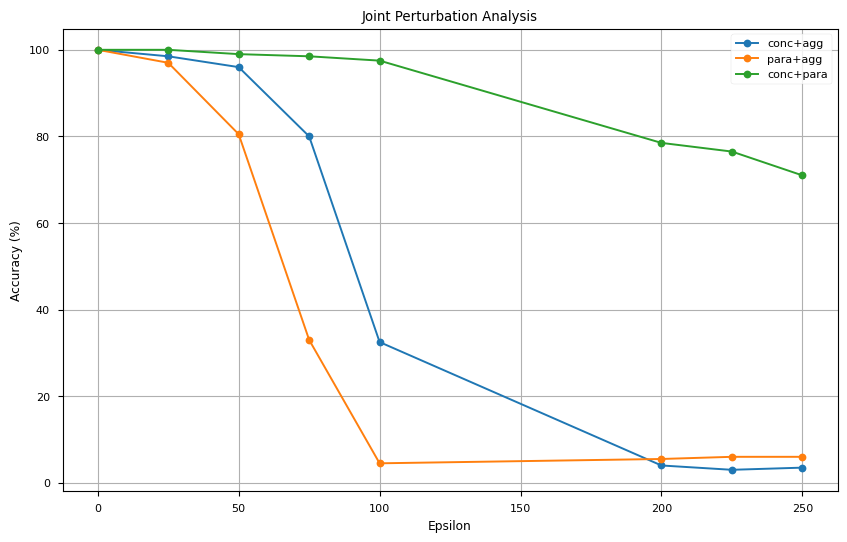

In [9]:
# Test script
def test_joint_perturbation():
    # Load model and data
    mnist_config = get_config("mnist_lambda1e-4_seed29.json")
    mnist_config.device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Get test dataloader
    _, _, mnist_test_dl = get_dataloader(mnist_config)
    
    # Create model components
    conceptizer = ConvConceptizer(**mnist_config.__dict__)
    parameterizer = ConvParameterizer(**mnist_config.__dict__)
    aggregator = SumAggregator(**mnist_config.__dict__)
    mnist_SENN = SENN(conceptizer, parameterizer, aggregator)
    
    # Load checkpoint if available
    try:
        mnist_checkpoint = load_checkpoint(mnist_config)
        mnist_SENN.load_state_dict(mnist_checkpoint['model_state'])
        print("Loaded checkpoint successfully")
    except:
        print("No checkpoint found, using untrained model")
    
    # Test different epsilon value, just add / change in list
    component_pairs = ["conc+agg", "para+agg", "conc+para"]
    eps_values = [0, 25, 50, 75, 100, 200, 225, 250]
    
    results = {}
    for comp_pair in component_pairs:
        print(f"\nTesting {comp_pair} perturbation:")
        pair_results = []
        for eps in eps_values:
            perturbed_input, acc = perturbed_accuracy_joint(
                mnist_SENN, 
                comp_pair,
                [conceptizer, parameterizer, aggregator],
                mnist_test_dl,
                mnist_config,
                eps,
                max_samples=100
            )
            pair_results.append((eps, acc))
        results[comp_pair] = pair_results
        
    # Plot results
    plt.figure(figsize=(10, 6))
    for comp_pair, res in results.items():
        eps_list, acc_list = zip(*res)
        plt.plot(eps_list, acc_list, marker='o', label=comp_pair)
    
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy (%)')
    plt.title('Joint Perturbation Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run test
test_joint_perturbation()

## Configuration

In [10]:
plt.style.use('seaborn-notebook')

<a name="reproduce_mnist"></a>
# 2. Reproducing MNIST Results

## Load MNIST Data and Config

In [11]:
mnist_config = get_config("mnist_lambda1e-4_seed29.json")
mnist_config.device = "cuda" if torch.cuda.is_available() else "cpu"
print(mnist_config.device)

cpu


In [12]:
from torch.utils.data import DataLoader

_, _, mnist_test_dl = get_dataloader(mnist_config)

test_dataset = mnist_test_dl.dataset
val_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [13]:
_, _, mnist_test_dl = get_dataloader(mnist_config)

print(mnist_config)


namespace(aggregator='SumAggregator', batch_size=200, cl_sizes=[1, 10, 20], concept_dim=1, concept_reg=1, conceptizer='ConvConceptizer', data_path='datasets/data/mnist_data', dataloader='mnist', device='cpu', dropout=0.5, epochs=5, eval_freq=270, exp_name='mnist_lambda1e-4_seed29', hidden_sizes=[320, 50], image_size=28, lr=0.0002, manual_seed=29, num_classes=10, num_concepts=5, parameterizer='ConvParameterizer', print_freq=100, robust_reg=0.0001, robustness_loss='mnist_robustness_loss', sparsity_reg=2e-05, train=True)


## Load Trained Model

In [14]:
conceptizer = ConvConceptizer(**mnist_config.__dict__)
parameterizer = ConvParameterizer(**mnist_config.__dict__)
aggregator = SumAggregator(**mnist_config.__dict__)

mnist_SENN = SENN(conceptizer, parameterizer, aggregator)

## Test Accuracy

First we run and evaluate the prediction performance of our model to check whether the results reported by the authors are reproducible or not. We are using the same hyperparameters and architecture that were reported by the authors.

In [15]:
print(mnist_config.device)
mnist_config.device = "cuda"  # Force GPU usage
print(mnist_config.device)


cpu
cuda


In [16]:
from senn.trainer import init_trainer

# Path to your config file
config_file = "configs/mnist_lambda1e-4_seed29.json"

# Initialize and run the trainer
trainer = init_trainer(config_file)
trainer.run()

 EXPERIMENT: mnist_lambda1e-4_seed29
{'aggregator': 'SumAggregator',
 'batch_size': 200,
 'cl_sizes': [1, 10, 20],
 'concept_dim': 1,
 'concept_reg': 1,
 'conceptizer': 'ConvConceptizer',
 'data_path': 'datasets/data/mnist_data',
 'dataloader': 'mnist',
 'device': 'cpu',
 'dropout': 0.5,
 'epochs': 5,
 'eval_freq': 270,
 'exp_name': 'mnist_lambda1e-4_seed29',
 'hidden_sizes': [320, 50],
 'image_size': 28,
 'lr': 0.0002,
 'manual_seed': 29,
 'num_classes': 10,
 'num_concepts': 5,
 'parameterizer': 'ConvParameterizer',
 'print_freq': 100,
 'robust_reg': 0.0001,
 'robustness_loss': 'mnist_robustness_loss',
 'sparsity_reg': 2e-05,
 'train': True}
Using device cpu
Loading data ...
SENN(
  (conceptizer): ConvConceptizer(
    (encoder): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0):

In [17]:
print(mnist_config.device)
mnist_config.device = "cpu"  # Force CPU usage
print(mnist_config.device)

cuda
cpu


In [18]:
# Create model
conceptizer = ConvConceptizer(**mnist_config.__dict__)
parameterizer = ConvParameterizer(**mnist_config.__dict__)
aggregator = SumAggregator(**mnist_config.__dict__)
mnist_SENN_trained = SENN(conceptizer, parameterizer, aggregator)

# Load checkpoint
mnist_checkpoint = load_checkpoint(mnist_config)
mnist_SENN_trained.load_state_dict(mnist_checkpoint['model_state'])



<All keys matched successfully>

In [19]:
# Then test accuracy
accuracy(mnist_SENN_trained, mnist_test_dl, mnist_config)

Test Mean Accuracy:  97.220 %


In [20]:
images_p = []
para_prob_vector = []
for eps in range(0,255,25):#range(0,270,25):
    #last_perturbed = perturbed_accuracy(mnist_SENN_trained, "parameterizer", [conceptizer, parameterizer, aggregator], val_loader, mnist_config, eps, 128)
    last_perturbed_input, last_perturbed_output, acc = perturbed_accuracy(mnist_SENN_trained, "parameterizer", [conceptizer, parameterizer, aggregator], val_loader, mnist_config, eps, 128)
    para_prob_vector.append(last_perturbed_output)
    images_p.append(last_perturbed_input)

  1%|▏         | 1/79 [00:00<00:13,  5.75it/s]


Epsilon 0 | Perturbed Accuracy: 100.00%


  1%|▏         | 1/79 [00:00<00:14,  5.36it/s]


Epsilon 25 | Perturbed Accuracy: 100.00%


  1%|▏         | 1/79 [00:00<00:13,  5.58it/s]


Epsilon 50 | Perturbed Accuracy: 98.44%


  1%|▏         | 1/79 [00:00<00:17,  4.55it/s]


Epsilon 75 | Perturbed Accuracy: 97.66%


  1%|▏         | 1/79 [00:00<00:14,  5.24it/s]


Epsilon 100 | Perturbed Accuracy: 96.88%


  1%|▏         | 1/79 [00:00<00:14,  5.31it/s]


Epsilon 125 | Perturbed Accuracy: 93.75%


  1%|▏         | 1/79 [00:00<00:40,  1.94it/s]


Epsilon 150 | Perturbed Accuracy: 85.16%


  1%|▏         | 1/79 [00:00<00:28,  2.75it/s]


Epsilon 175 | Perturbed Accuracy: 81.25%


  1%|▏         | 1/79 [00:00<00:31,  2.46it/s]


Epsilon 200 | Perturbed Accuracy: 78.91%


  1%|▏         | 1/79 [00:00<00:45,  1.70it/s]


Epsilon 225 | Perturbed Accuracy: 75.78%


  1%|▏         | 1/79 [00:00<00:23,  3.28it/s]

Epsilon 250 | Perturbed Accuracy: 71.09%


In [21]:
import torch

def calculate_entropy(prob_vector):
    # Ensure the input is a tensor
    if not isinstance(prob_vector, torch.Tensor):
        prob_vector = torch.tensor(prob_vector)
    
    # Calculate entropy along dimension 1
    prob_vector = torch.softmax(prob_vector, dim=1)
    entropy = -torch.sum(prob_vector * torch.log(prob_vector + 1e-9), dim=1)
    
    return entropy

# Example usage

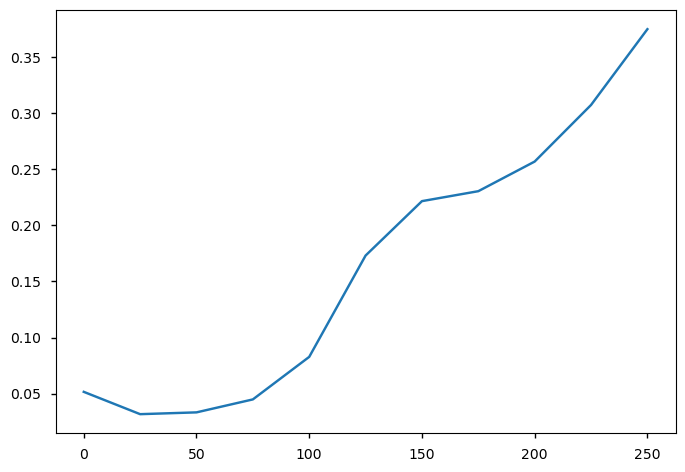

In [22]:
para_entropies = []
for i in range(len(para_prob_vector)):
    para_entropies.append(calculate_entropy(para_prob_vector[i]).mean().item())


plt.plot(range(0,255,25), para_entropies)

In [23]:
images_c = []
conc_prob_vector = []
for eps in range(0,255,25):#range(0,270,25):
    #last_perturbed = perturbed_accuracy(mnist_SENN_trained, "parameterizer", [conceptizer, parameterizer, aggregator], val_loader, mnist_config, eps, 128)
    last_perturbed_input, last_perturbed_output, acc = perturbed_accuracy(mnist_SENN_trained, "conceptizer", [conceptizer, parameterizer, aggregator], val_loader, mnist_config, eps, 128)
    conc_prob_vector.append(last_perturbed_output)
    images_c.append(last_perturbed_input)

  1%|▏         | 1/79 [00:00<00:11,  6.97it/s]


Epsilon 0 | Perturbed Accuracy: 100.00%


  1%|▏         | 1/79 [00:00<00:10,  7.18it/s]


Epsilon 25 | Perturbed Accuracy: 100.00%


  1%|▏         | 1/79 [00:00<00:10,  7.63it/s]


Epsilon 50 | Perturbed Accuracy: 98.44%


  1%|▏         | 1/79 [00:00<00:10,  7.79it/s]


Epsilon 75 | Perturbed Accuracy: 96.88%


  1%|▏         | 1/79 [00:00<00:15,  5.19it/s]


Epsilon 100 | Perturbed Accuracy: 94.53%


  1%|▏         | 1/79 [00:00<00:12,  6.02it/s]


Epsilon 125 | Perturbed Accuracy: 85.16%


  1%|▏         | 1/79 [00:00<00:16,  4.83it/s]


Epsilon 150 | Perturbed Accuracy: 81.25%


  1%|▏         | 1/79 [00:00<00:20,  3.72it/s]


Epsilon 175 | Perturbed Accuracy: 78.12%


  1%|▏         | 1/79 [00:00<00:20,  3.77it/s]


Epsilon 200 | Perturbed Accuracy: 77.34%


  1%|▏         | 1/79 [00:00<00:26,  2.97it/s]


Epsilon 225 | Perturbed Accuracy: 75.00%


  1%|▏         | 1/79 [00:00<00:23,  3.26it/s]

Epsilon 250 | Perturbed Accuracy: 70.31%


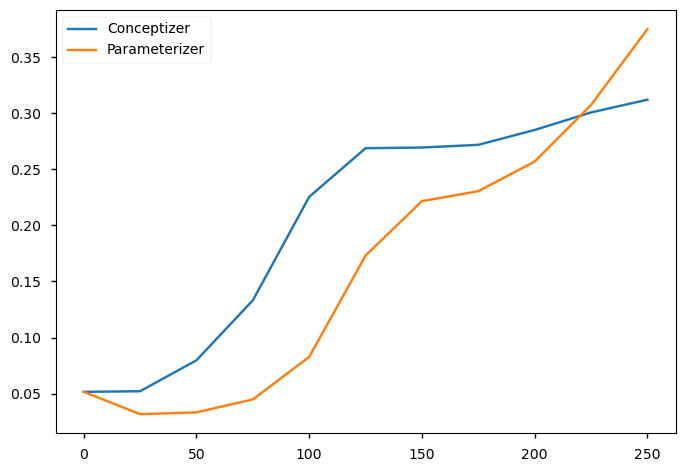

In [25]:
from math import log
unif_prob_vector = torch.full((len(range(0,255,25)), 128, 10), log(0.1))

conc_entropies = []
for i in range(len(conc_prob_vector)):
    conc_entropies.append(calculate_entropy(conc_prob_vector[i]).mean().item())

unif_entropies = []
for i in range(len(unif_prob_vector)):
    unif_entropies.append(calculate_entropy(unif_prob_vector[i]).mean().item())


#plt.plot(range(0,255,25), unif_entropies)
plt.plot(range(0,255,25), conc_entropies)
plt.plot(range(0,255,25), para_entropies)
plt.legend(['Conceptizer', 'Parameterizer'])

<Figure size 800x600 with 0 Axes>

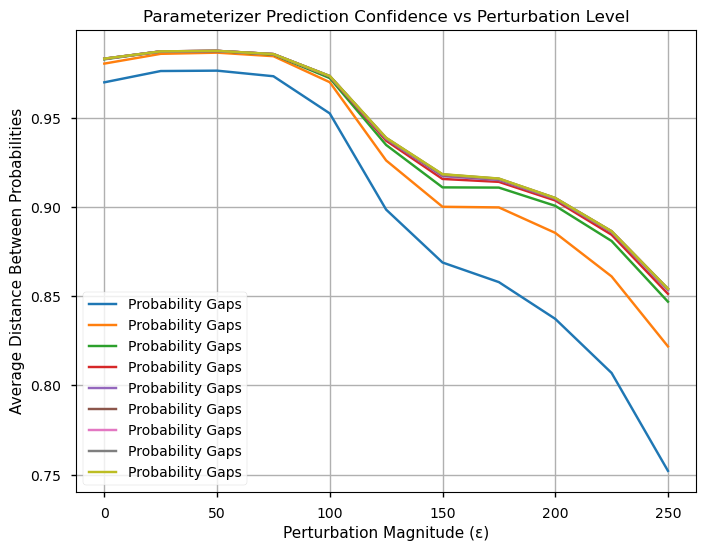

In [32]:
import numpy as np

def sort_subarrays_desc(arr):
    # Ensure the input is a numpy array
    for i in range(len(arr)):
        if not isinstance(arr[i], np.ndarray):
            arr[i] = arr[i].detach().numpy()
    
    # Sort each subarray of size 10 in descending order
    sorted_arr = np.sort(arr, axis=-1)[:, :, ::-1]
    
    return np.exp(sorted_arr)

def calculate_distances(arr):
    # Calculate the distances between the 1st and the rest of the probabilities
    distances = arr[:, :, 0:1] - arr[:, :, 1:]
    return distances

# Example usage
sorted_arr_conc = sort_subarrays_desc(conc_prob_vector)
conc_avg_distances = np.mean(calculate_distances(sorted_arr_conc),axis=1)

sorted_arr_para = sort_subarrays_desc(para_prob_vector)
para_avg_distances = np.mean(calculate_distances(sorted_arr_para),axis=1)

plt.figure(figsize=(8, 6))

plt.figure(figsize=(8, 6))

# Plot the distances
plt.plot(range(0,255,25), para_avg_distances, label='Probability Gaps')

plt.xlabel('Perturbation Magnitude (ε)')
plt.ylabel('Average Distance Between Probabilities')
plt.title('Parameterizer Prediction Confidence vs Perturbation Level')
plt.grid(True)
plt.legend()





In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(0,255,25), conc_avg_distances)
plt.xlabel('Perturbation Magnitude (ε)')
plt.ylabel('Average Distance Between Top and Other Probabilities')
plt.title('Conceptizer Prediction Confidence vs Perturbation Level')
plt.grid(True)
plt.legend(['Conceptizer Output Probability Gaps'])

plt.text(0.95, 0.95, 
         'Higher values indicate more confident predictions\n(larger gaps between top and other class probabilities)',
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

In [ ]:
images_a = []
agg_prob_vector = []
a_acc = []
for eps in range(0,255,25):#range(0,270,25):
    #last_perturbed = perturbed_accuracy(mnist_SENN_trained, "parameterizer", [conceptizer, parameterizer, aggregator], val_loader, mnist_config, eps, 128)
    last_perturbed_input, last_perturbed_output, acc = perturbed_accuracy(mnist_SENN_trained, "aggregator", [conceptizer, parameterizer, aggregator], val_loader, mnist_config, eps, 128)
    a_acc.append(acc)
    agg_prob_vector.append(last_perturbed_output)
    images_a.append(last_perturbed_input)

In [24]:
plt.plot(range(0,255,25), a_acc)

NameError: name 'a_acc' is not defined

The obtained test accuracy closely matches the reported range of the authors which was 99.1% to 98.7% for different lambda values. We used $\lambda = 1e-4$  for the tested model. For further hyperparameter details you can consult the config files used or the table in the report. 

## Test Explanations

The following function randomly samples from a test batch and produces explanations for their classification. With this experiment we want to qualitatively examine the interpretibility of the generated explanations. The model used in this experiment is the same as above.

In [ ]:
show_explainations(mnist_SENN, mnist_test_dl, 'mnist')

The relevance scores of the explanations shown in the original paper are exclusively values close to either positive or negative one. The relevance scores in our explanations are more diverse.

The following function finds the top nine prototypical test examples that activate a certain concept the most. This visualization method was also used by the authors.

In [ ]:
show_prototypes(mnist_SENN, mnist_test_dl, 'activation')

In the original paper the prototypes of one concept are mostly of the same digit class. While this tendency can also be observed in some of our concept representations in other cases the concept is not prototypical for a certain digit class.

In general we do not consider the vast majority of the explanations to be plausible and human interpretable. Therefore, this experiment is not reproducible. We believe that the authors picked only some of the few plausible examples by hand rather than showing randomly sampled results. We consider the poor interpretebility of the explanations a severe limitation of the framework. We argue that the lack of interpretability is at least partially caused by the way of representing the concepts. Selecting prototypes based only on the highest activation for each concept seems for us to be a crude method that fails to capture the real semantic meaning of the concept.

## Extending Concept Representation Techniques

The authors proposed two alternative methods for representing concepts as future work. As we argue in the previous experiment that the concept visualization has potential for improovement we tryed both of these methods.

We start with another prototype visualization method which we call '$\textit{highest contrast}$'. The difference to the standard method (highest activation) is that the prototypes are not selected by only optimizing for highest activation for a certain concept but by also considering that all remaining concepts should be activated as little as possible at the same time.

The following function finds the prototypes with the highest contrast method using the same model as above for highest activation

In [ ]:
show_prototypes(mnist_SENN, mnist_test_dl, 'contrast')

We find that the prototypes are not more human interpretable than with the highest activation method. The efect of concepts not being represented by a single digit class is even stronger for the highest contrast method.
Note that the two visualization methods are inconsistent in some cases because the interpretation of the same underlying concept changes. A good example of this is Concept 4. In the highest activation method it represented the digit class three but with the highest contrast method it is represented by many different digit classes that could be interpreted as sharing the property of roundness. 
Finding an interpretation of the concept representation is left to the user and is therefore highly subjective. 

The next function uses the second approach proposed by the authors. This time the concepts are not represented by prototypes but by the weights of the concolutional concept encoders. We use the last layer of the encoder because deeper layers represent more high-level features.

In [ ]:
show_prototypes(mnist_SENN, mnist_test_dl, 'filter')

The filters do not exhibit any human interpretable features. Considering the limited depth of the concept encoder, relatively small filter size and the simplicity of the data this is not surprising. However, we think a more suitable approach would be to visualize the filter activations of transposed convolutions applied on the concept specific filters respectively.

## Tradeoff: Accuracy vs. Robustness 

In this experiment we want to analyze the negative impact of the robustness loss rgularization on the accuracy. We therefore incrementally increase the amount of regularization and training the same model for each of the $\lambda$-values. Because on MNIST the results were stable we only use one seed to report the results.

Below you can see the config files of the five models that are used to generate the plot.

In [26]:
config_list = ['mnist_lambda1e-4_seed29.json', 'mnist_lambda1e-3_seed29.json', 'mnist_lambda1e-2_seed29.json', 
               'mnist_lambda1e-1_seed29.json', 'mnist_lambda1e-0_seed29.json']

The valid flag here is only used in this notebook to speed up calculations. The five models are not evaluated on the test set but instead the validation accuracies recorded during training are loaded. In the report we used the test accuracies which are almost the same as we did not do any hyperparameter search on the validation set.

In [ ]:
# NOTE: This will read the saved validation accuracies to speed up the process
# in the report we evaluate on the test set
_ = plot_lambda_accuracy(config_list, num_seeds=1, valid=True)

There is only a very small downward trend in accuracy up to the extreme value of $\lambda = 1$ where the accuracy drops a lot. The general trend is consistent with the authors result but they do not report the huge drop for $\lambda=1$.

<a name="reproduce_compas"></a>
# 3. Reproducing COMPAS Results

## Load Test Data and Configuration

In [28]:
compas_config = get_config("compas_lambda1e-4_seed555.json")
compas_config.device = "cpu"

In [ ]:
_, _, compas_test_dl = get_dataloader(compas_config)

## Load Trained Model

In [30]:
conceptizer = IdentityConceptizer(**compas_config.__dict__)
parameterizer = LinearParameterizer(**compas_config.__dict__)
aggregator = SumAggregator(**compas_config.__dict__)

compas_SENN = SENN(conceptizer, parameterizer, aggregator)

In [ ]:
compas_checkpoint = load_checkpoint(compas_config)

compas_SENN.load_state_dict(compas_checkpoint['model_state'])

## Test Accuracy

Same as for MNIST we run and evaluate the prediction performance of our COMPAS model to check whether the results reported by the authors are reproducible or not. We are using the same hyperparameters and architecture that were reported by the authors for this dataset again.

In [ ]:
accuracy(compas_SENN, compas_test_dl, compas_config)

The obtained test accuracy closely matches the reported result of the authors (82%). We used $\lambda = 1e-4$  for the tested model. For further hyperparameter details you can consult the config files used or the table in the report. 

## Test Explanations

For completeness sake we also visualize two examples of explanations for the COMPAS dataset. As here no concepts are learned ( instead the raw inputs are used) the analysis of these explanations is not that interesting and therefore only shown in the reprt's appendix.

In [ ]:
# show_explainations(compas_SENN, compas_test_dl, 'compas', concept_names=compas_config.concept_names)
show_explainations(compas_SENN, compas_test_dl, 'compas', concept_names=[f"C{i}" for i in range(11)])

## Tradeoff: Accuracy vs. Robustness

Analogously, to the regularization study performed on MNIST (see above) we do the same for the COMPAS dataset. The difference is that we train the model on three different seeds per lambda value. The used config files are listed below.

In [25]:
config_list = [["compas_lambda1e-4_seed111.json","compas_lambda1e-4_seed333.json","compas_lambda1e-4_seed555.json"],
               ["compas_lambda1e-3_seed111.json","compas_lambda1e-3_seed333.json","compas_lambda1e-3_seed555.json"],
               ["compas_lambda1e-2_seed111.json","compas_lambda1e-2_seed333.json","compas_lambda1e-2_seed555.json"],
               ["compas_lambda1e-1_seed111.json","compas_lambda1e-1_seed333.json","compas_lambda1e-1_seed555.json"],
               ["compas_lambda1e-0_seed111.json","compas_lambda1e-0_seed333.json","compas_lambda1e-0_seed555.json"]]

Again we use the valid flag in this notebook to speed up computations (see explanation  in the respective MNIST experiment)

In [ ]:
# NOTE: This will read the saved validation accuracies to speed up the process
# in the repoert we evaluate on the test set
_ = plot_lambda_accuracy(config_list, num_seeds=3, valid=True)

We observe the same downward trend in accuracy for increasing regularization that was reported by the authors. However, the magnitude of the decrease is a lot higher in our experiments. The authors only report a drop of about 4% points while in our experiment the difference in accuracy between the two extreme values is approximately 15% points. 

<a name="robustness_study"></a>
# 4. Study of Robustness

Inspired by the robustness study the authors conducted by perturbating an input image with Guassian noise, we decided to take a different approach. Instead of using the input image with different levels of noise, we try to find semantically similar images in the dataset and plot their concepts and relevance scores. To cluster the images we train an autoencoder, whose architecture can be found in the appendix of the report, and perform k-nearest-neighbour search of the latent space (Euclidean distance) to get the images from the dataset that look most similar to the query image. As a result, we get k + 1 images for which we compare the concept activation and relevance scores.

## Load pre-trained MNIST autoencoder

In [27]:
from senn.utils.MNIST_autoencoder import AETrainer, get_most_similar

ae_trainer = AETrainer(mnist_test_dl, batch_size=200)
ae_trainer.load_model("senn/utils/MNIST_autoencoder_pretrained.pt")

**Get the latent vector for all the inputs from the test set**

In [28]:
mnist_latents = ae_trainer.get_latent_reps(mnist_test_dl)

## Test robustness for visually similar images

In [29]:
# Get the indices of the closest vectors
nearest_num = 5
query_index = 0

distances, indices = get_most_similar(latents=mnist_latents,
                                      query=mnist_latents[query_index],
                                      number=nearest_num)

In [ ]:
# prepare input images from the testloader 
test_images = torch.stack([mnist_test_dl.dataset[index][0] for index in indices[0]])

fig = get_comparison_plot(test_images, mnist_SENN)
fig.tight_layout()

The experiment shows that the generated explanations are robust because the relevances as well as the concept activations are very similar for these perceptually similar test examples.

<a name="DiSENN"></a>
# 5. Self-Explaining Neural Networks with Disentanglement

DiSENN incorporates a constrained variational inference framework on a 
SENN Concept Encoder to learn disentangled representations of the 
basis concepts as in [2]. The basis concepts are then independently
sensitive to single generative factors leading to better interpretability 
and lesser overlap with other basis concepts. Such a strong constraint 
better fulfills the "diversity" desiderata for basis concepts
in a Self-Explaining Neural Network.


References  
[1] Alvarez Melis, et al.
"Towards Robust Interpretability with Self-Explaining Neural Networks" NIPS 2018  
[2] Irina Higgins, et al. 
”β-VAE: Learning basic visual concepts with a constrained variational framework.” ICLR 2017. 

## Load Data and Configuration

In [31]:
disenn_config = get_config("MNIST_DiSENN.json")

In [32]:
_, _, mnist_test_dl = get_dataloader(disenn_config)

## Load Trained Model

In [33]:
conceptizer = VaeConceptizer(**disenn_config.__dict__)
parameterizer = ConvParameterizer(**disenn_config.__dict__)
aggregator = SumAggregator(**disenn_config.__dict__)

disenn = DiSENN(conceptizer, parameterizer, aggregator)

In [ ]:
disenn_checkpoint = load_checkpoint(disenn_config)
disenn.load_state_dict(disenn_checkpoint['model_state'])

## Test Accuracy

In [ ]:
accuracy(disenn, mnist_test_dl, disenn_config)

## Test Explanations

**Generate Prototypes from Disentangled Concepts**

In [36]:
xb, yb = next(iter(mnist_test_dl))

**Find all images of digit 3**

In [ ]:
(yb==3).nonzero()

In [ ]:
x = xb[18].cpu()
fname = "/digit3a.png"
disenn.explain(x, contrast_class=8, traversal_range=0.45,
              gridsize=(1,6), col_span=3, figure_size=(18,3), show=True,
              save_as="results/"+disenn_config.exp_name+fname, use_cdf=True)

In [ ]:
x = xb[30].cpu()
fname = "/digit3b.png"
disenn.explain(x, contrast_class=8, traversal_range=0.45,
              gridsize=(1,6), col_span=3, figure_size=(18,3), show=True,
              save_as="results/"+disenn_config.exp_name+fname, use_cdf=True)

**A random digit**

In [ ]:
x = xb[0].cpu()
fname = "/digit.png"
disenn.explain(x, contrast_class=0, traversal_range=0.45,
              gridsize=(1,6), col_span=3, figure_size=(18,3), show=True,
              save_as="results/"+disenn_config.exp_name+fname, use_cdf=True)